### Major definition

"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.

The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. 

The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction.

The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and very date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. 

The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the

In [2]:
import numpy as np
import pandas as pd
import math
from tqdm import tqdm_notebook
import os
import time
import datetime

## visualiation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## preprocessing and metrics
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error

## classifiers
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier# gradient boosting
from sklearn.svm import NuSVC, SVC
import lightgbm as lgb

## neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Adamax, Nadam
from keras.callbacks import EarlyStopping

## optimization
from bayes_opt import BayesianOptimization

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.options.display.precision = 15
pd.pandas.set_option('display.max_columns', None)

/Users/apple/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/apple/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/apple/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/apple/anaconda3/lib/python3.6/site-packa

# 1. EDA: columnar missing vals, distribution and some plots

In [3]:
# read data
df = pd.read_csv('online_shoppers_intention.csv')
print(df.shape)
df.head()

(12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
def missing_data(data):
    '''
    display of missing information per column
    '''
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

def plot_feature_distribution(df1, df2, label1, label2, features):
    '''
    numerical feature ditribution comparator for binary labelled segments
    '''
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,3,figsize=(10,10))

    for feature in features:
        try:
            i += 1
            plt.subplot(3,3,i)
            sns.distplot(df1[feature], hist=False,label=label1)
            sns.distplot(df2[feature], hist=False,label=label2)
            plt.xlabel(feature, fontsize=9)
            locs, labels = plt.xticks()
            plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
            plt.tick_params(axis='y', which='major', labelsize=6)
        except:
            continue
    plt.show();
    
def count_ctgy_spread(df,ctgy_cols):
    '''
    count in each categorical column,
    how many variety they have
    returns the suggested methods to process columns, using config
    '''
    res = {}
    advice = {}
    for col in ctgy_cols:
        val = df[col].value_counts().reset_index().shape[0]
        if val <= 6:
            advice[col] = 'one_hot'
        elif val > 6 and val <= 10:
            advice[col] = 'mid_level'
        else:
            advice[col] = 'encoding'
        
        res[col] = val
    print('column:number of unique records')
    return res,advice

In [5]:
# categorical feature coersive conversion
df['SpecialDay'] = df['SpecialDay'].astype('O')
df['OperatingSystems'] = df['OperatingSystems'].astype('O')
df['Browser'] = df['Browser'].astype('O')
df['Region'] = df['Region'].astype('O')
df['TrafficType'] = df['TrafficType'].astype('O')
df['Revenue'] = df['Revenue'].astype(int)

# convenient vars for columns
feature_cols = df.columns.tolist()
feature_cols.remove('Revenue')
feature_obj_cols = df.select_dtypes('O').columns.tolist()
feature_num_cols = [x for x in feature_cols if x not in feature_obj_cols]

#show columnar missing values conditions
missing_data(df)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
Total,14,14,14,14,14,14,14,14,0,0,0,0,0,0,0,0,0,0
Percent,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0,0,0,0,0,0,0,0,0,0
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,bool,int64


In [6]:
#fillna on the numerical columns, using mean
for col in df.select_dtypes(exclude='O').columns.tolist():
    df[col].fillna(df[col].mean(),inplace=True)
    
# check if the data contains any NULL values
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## Dependent Variable

There are 15.47% target values with 1


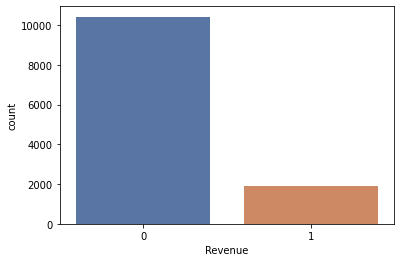

In [7]:
# Distribution of customers with Revenue 

sns_plot = sns.countplot(df['Revenue'], palette='deep')
#sns_plot.figure.savefig('image/01_revenue.png')

print("There are {:.2%} target values with 1".format(df["Revenue"].value_counts()[1]/df.shape[0]))

## Independent Variable

## Numerical Features

<Figure size 432x288 with 0 Axes>

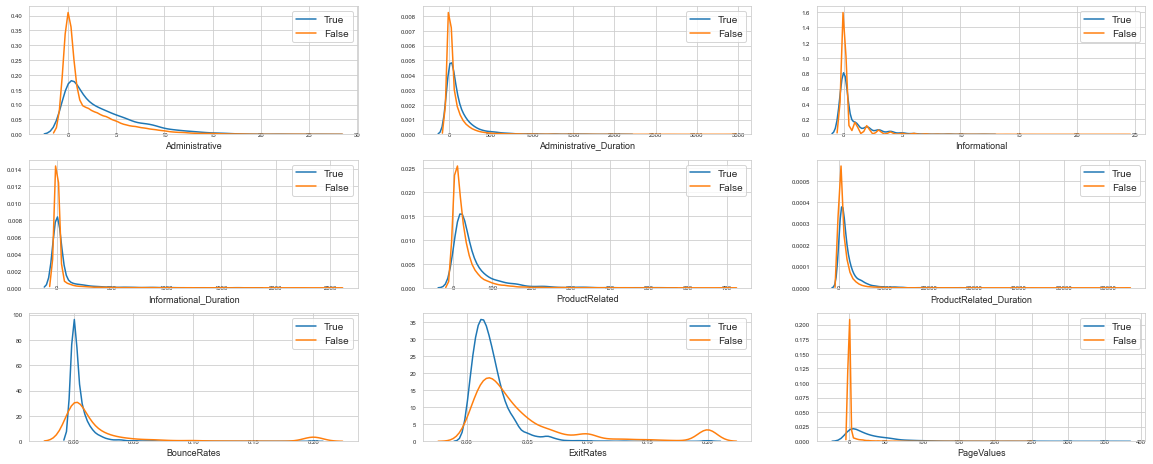

In [8]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,3,figsize=(20,8))

    for feature in features:
        i += 1
        plt.subplot(3,3,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    #plt.savefig('image/02_pages.png')    
    plt.show()
    
revenue_y = df.loc[df['Revenue'] == True]
revenue_n = df.loc[df['Revenue'] == False]
features = df.columns.values[0:9]
plot_feature_distribution(revenue_y, revenue_n, 'True', 'False', features)

In [9]:
def eda_plot(df, colname):
    sns_plot = sns.countplot(df[colname], palette='hls')

    # Percentage of total
    chart = pd.crosstab(df[colname], df['Revenue'])
    chart = chart.div(chart.sum(1).astype(float), axis = 0)

    plot = chart.plot(kind = 'bar', stacked = True, color=sns.color_palette('deep'))
    plot.set_xticklabels(plot.get_xticklabels(), rotation=0)
    plt.show()

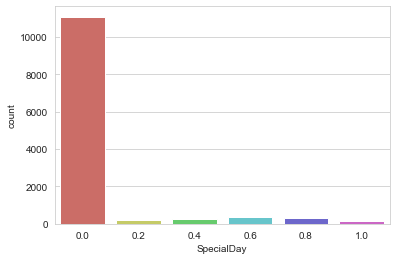

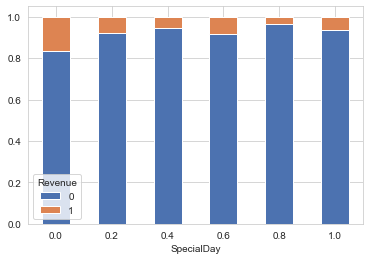

In [10]:
## Special Day
eda_plot(df, 'SpecialDay')

## Categorical Features

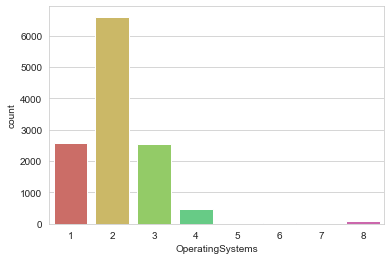

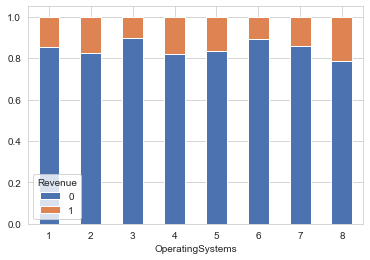

In [11]:
# Operating System
eda_plot(df, 'OperatingSystems')

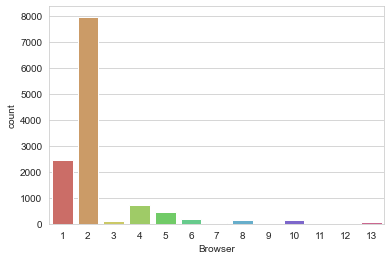

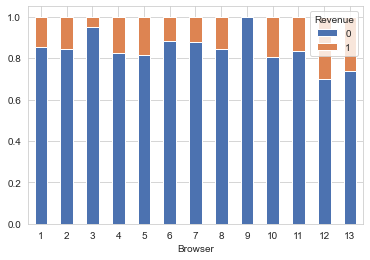

In [12]:
# Browser
eda_plot(df, 'Browser')

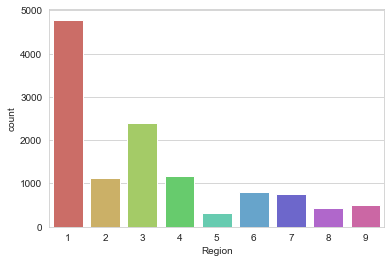

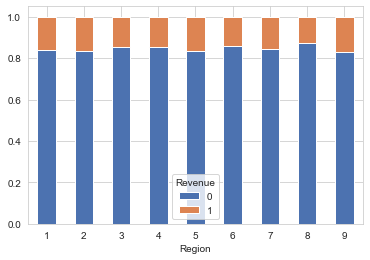

In [13]:
# Region
eda_plot(df, 'Region')

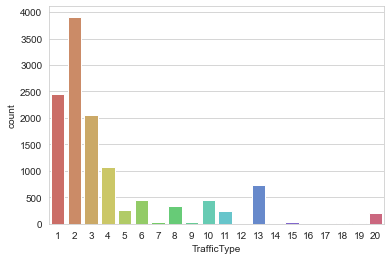

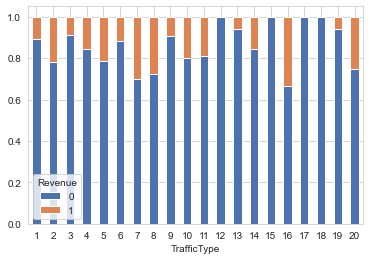

In [14]:
# Traffic Type
eda_plot(df, 'TrafficType')

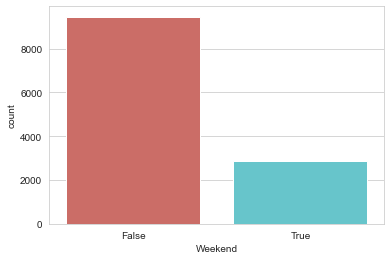

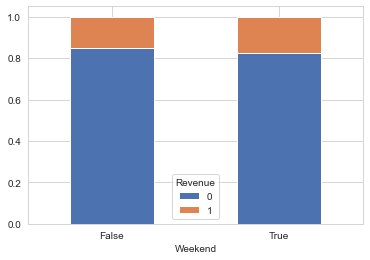


% of purchase on weekend = 17.40%
% of purchase on weekday = 14.89%


In [15]:
## Weekend 
eda_plot(df, 'Weekend')

weekend = int(df.loc[df['Weekend']==True, 'Weekend'].count())
weekday = int(df.loc[df['Weekend']==False, 'Weekend'].count())
weekend_revenue = int(df.loc[(df['Weekend']==True) & (df['Revenue']==True), ['Weekend']].count())
weekday_revenue = int(df.loc[(df['Weekend']==False) & (df['Revenue']==True), ['Weekend']].count())

print('\n% of purchase on weekend = {0:.2%}'.format(weekend_revenue/weekend))
print('% of purchase on weekday = {0:.2%}'.format(weekday_revenue/weekday))

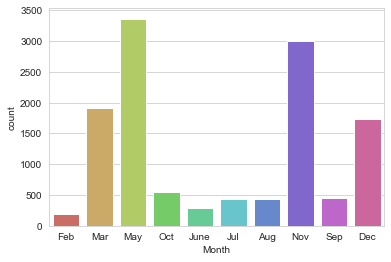

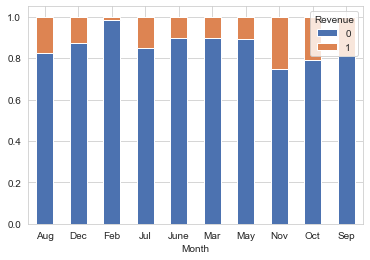

% of purchase in Feb = 1.63%
% of purchase in Mar = 10.07%
% of purchase in May = 10.85%
% of purchase in Jun = 10.07%
% of purchase in Jul = 15.28%
% of purchase in Aug = 17.55%
% of purchase in Sep = 19.20%
% of purchase in Oct = 20.95%
% of purchase in Nov = 25.35%
% of purchase in Dec = 12.51%


In [16]:
## Month
eda_plot(df, 'Month')

feb = int(df.loc[df['Month']=='Feb', 'Month'].count())
mar = int(df.loc[df['Month']=='Mar', 'Month'].count())
apr = int(df.loc[df['Month']=='Apr', 'Month'].count())
may = int(df.loc[df['Month']=='May', 'Month'].count())
jun = int(df.loc[df['Month']=='June', 'Month'].count())
jul = int(df.loc[df['Month']=='Jul', 'Month'].count())
aug = int(df.loc[df['Month']=='Aug', 'Month'].count())
sep = int(df.loc[df['Month']=='Sep', 'Month'].count())
oct = int(df.loc[df['Month']=='Oct', 'Month'].count())
nov = int(df.loc[df['Month']=='Nov', 'Month'].count())
dec = int(df.loc[df['Month']=='Dec', 'Month'].count())

feb_rev = int(df.loc[(df['Month']=='Feb') & (df['Revenue']==True), 'Month'].count())
mar_rev = int(df.loc[(df['Month']=='Mar') & (df['Revenue']==True), 'Month'].count())
apr_rev = int(df.loc[(df['Month']=='Apr') & (df['Revenue']==True), 'Month'].count())
may_rev = int(df.loc[(df['Month']=='May') & (df['Revenue']==True), 'Month'].count())
jun_rev = int(df.loc[(df['Month']=='June') & (df['Revenue']==True), 'Month'].count())
jul_rev = int(df.loc[(df['Month']=='Jul') & (df['Revenue']==True), 'Month'].count())
aug_rev = int(df.loc[(df['Month']=='Aug') & (df['Revenue']==True), 'Month'].count())
sep_rev = int(df.loc[(df['Month']=='Sep') & (df['Revenue']==True), 'Month'].count())
oct_rev = int(df.loc[(df['Month']=='Oct') & (df['Revenue']==True), 'Month'].count())
nov_rev = int(df.loc[(df['Month']=='Nov') & (df['Revenue']==True), 'Month'].count())
dec_rev = int(df.loc[(df['Month']=='Dec') & (df['Revenue']==True), 'Month'].count())

print('% of purchase in Feb = {0:.2%}'.format(feb_rev/feb))
print('% of purchase in Mar = {0:.2%}'.format(mar_rev/mar))
# print('% of purchase in Apr = {0:.2%}'.format(apr_rev/apr))
print('% of purchase in May = {0:.2%}'.format(may_rev/may))
print('% of purchase in Jun = {0:.2%}'.format(jun_rev/jun))
print('% of purchase in Jul = {0:.2%}'.format(jul_rev/jul))
print('% of purchase in Aug = {0:.2%}'.format(aug_rev/aug))
print('% of purchase in Sep = {0:.2%}'.format(sep_rev/sep))
print('% of purchase in Oct = {0:.2%}'.format(oct_rev/oct))
print('% of purchase in Nov = {0:.2%}'.format(nov_rev/nov))
print('% of purchase in Dec = {0:.2%}'.format(dec_rev/dec))

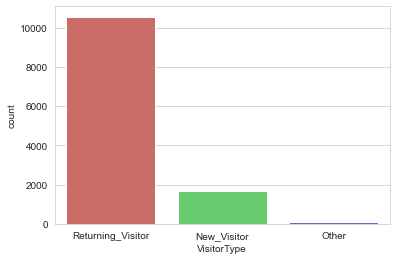

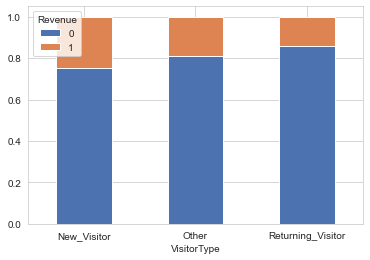

% of returning visitor = 86%
% of new visitor = 14%
% of other visitor = 1%

% of purchase for returning visitor = 13.93%
% of purchase for new visitor = 24.91%


In [17]:
## Visitor Type
eda_plot(df, 'VisitorType')

total = df.shape[0]
returning_visitor = int(df.loc[df['VisitorType']=='Returning_Visitor', 'VisitorType'].count())
new_visitor = int(df.loc[df['VisitorType']=='New_Visitor', 'VisitorType'].count())
other_visitor = int(df.loc[df['VisitorType']=='Other', 'VisitorType'].count())
returning_visitor_revenue = int(df.loc[(df['VisitorType']=='Returning_Visitor') & (df['Revenue']==True), ['VisitorType']].count())
new_visitor_revenue = int(df.loc[(df['VisitorType']=='New_Visitor') & (df['Revenue']==True), ['VisitorType']].count())

print('% of returning visitor = {0:.0%}'.format(returning_visitor/total))
print('% of new visitor = {0:.0%}'.format(new_visitor/total))
print('% of other visitor = {0:.0%}'.format(other_visitor/total))

print('\n% of purchase for returning visitor = {0:.2%}'.format(returning_visitor_revenue/returning_visitor))
print('% of purchase for new visitor = {0:.2%}'.format(new_visitor_revenue/new_visitor))

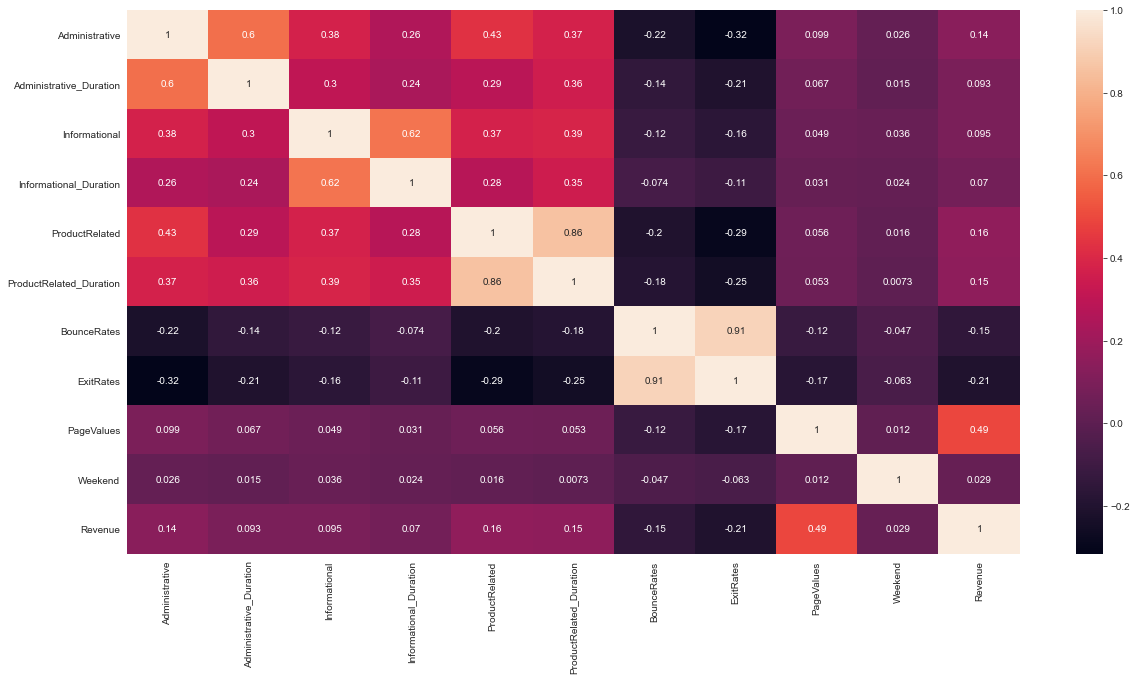

In [18]:
# correlation
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True)

## Train-test split

In [19]:
train, test = train_test_split(df, test_size=0.2,random_state = 42)

# 2. Build benchmark model, off the shelf LR

In [20]:
def benchmark_model(df,target_col):
    '''
    benchmark model, using simple off shelf models
    we use LR off shelf as benchmark model
    '''
    #fillna on the numerical columns, using mean
    for col in df.select_dtypes(exclude='O').columns.tolist():
        df[col].fillna(df[col].mean(),inplace=True)
    
    #remove target column, keep the features columns
    all_cols = df.columns.tolist()
    all_cols.remove(target_col)
    
    #split dataset immediately avoid data leakage
    train, test = train_test_split(df, test_size=0.2)
    
    #use get dummies on all categoricals
    X_train = pd.get_dummies(train[all_cols],drop_first=True)
    y_train = train[target_col]
    
    X_test = pd.get_dummies(test[all_cols],drop_first=True)
    y_test = test[target_col]

    
    # Get missing columns in the training test
    missing_cols = set( X_train.columns ) - set( X_test.columns )
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        X_test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    X_test = X_test[X_train.columns]

    ns_probs = [0 for _ in range(len(y_test))]
    # fit a model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

    return None

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.881


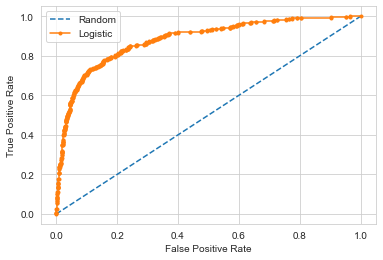

In [21]:
ac = benchmark_model(df,target_col='Revenue')

### Feature engineering

The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and very date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.

In [22]:
def decayed_tte(x):
    '''
    time to event
    x input, rescaled output
    '''
    #if x is small, means not impactful, if x=1, then it's very close to special day
    return math.exp(x-1)

def get_likelihood_feature(df,feature,target):
    '''
    get a factual information for feature
    conversion probability using singel column
    '''
    print("processing feature:%s"%feature)
    non_rev = train[train[target]==0][feature].value_counts().reset_index().rename(columns={'index':'var',feature:'count_non_rev'})
    
    rev = train[train[target]==1][feature].value_counts().reset_index().rename(columns={'index':'var',feature:'count_rev'})
    #inner joint result
    merged_res = pd.merge(non_rev,rev,on='var',how='inner')
    merged_res['conversion_prob'] = merged_res['count_rev']/(merged_res['count_non_rev']+merged_res['count_rev'])
    
    feature_count = merged_res['var'].tolist()
    prob = merged_res['conversion_prob'].tolist()
    prob_dict = dict(zip(feature_count,prob))
    
    return prob_dict

def get_probability(rowin,d):
    '''
    based on a dict,
    associate the probability
    if not in keys, leave as None
    '''
    if rowin in d.keys():
        return d[rowin]
    else:
        return None

In [23]:
def challenger_model(train,test,one_hot,target_col):
    all_cols = train.columns.tolist()
    all_cols.remove(target_col)
    
    if one_hot:
        #use get dummies on all categoricals
        X_train = pd.get_dummies(train[all_cols],drop_first=True)
        y_train = train[target_col]

        X_test = pd.get_dummies(test[all_cols],drop_first=True)
        y_test = test[target_col]


        # Get missing columns in the training test
        missing_cols = set( X_train.columns ) - set( X_test.columns )
        # Add a missing column in test set with default value equal to 0
        for c in missing_cols:
            X_test[c] = 0
        # Ensure the order of column in the test set is in the same order than in train set
        X_test = X_test[X_train.columns]
    
    else:
        X_train = train[all_cols]
        y_train = train[target_col]
        X_test = test[all_cols]
        y_test = test[target_col]
        
    ns_probs = [0 for _ in range(len(y_test))]
    # fit a model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    return None

### Dealing with categorical features

In [24]:
def mean_encode(train_data, test_data, columns, target_col, reg_method=None,
                alpha=0, add_random=False, rmean=0, rstd=0.1, folds=1):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    target_mean_global = train_data[target_col].mean()
    for col in columns:
        # Getting means for test data
        nrows_cat = train_data.groupby(col)[target_col].count()
        target_means_cats = train_data.groupby(col)[target_col].mean()
        target_means_cats_adj = (target_means_cats*nrows_cat + 
                                 target_mean_global*alpha)/(nrows_cat+alpha)
        # Mapping means to test data
        encoded_col_test = test_data[col].map(target_means_cats_adj)
        # Getting a train encodings
        if reg_method == 'expanding_mean':
            train_data_shuffled = train_data.sample(frac=1, random_state=1)
            cumsum = train_data_shuffled.groupby(col)[target_col].cumsum() - train_data_shuffled[target_col]
            cumcnt = train_data_shuffled.groupby(col).cumcount()
            encoded_col_train = cumsum/(cumcnt)
            encoded_col_train.fillna(target_mean_global, inplace=True)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))
        elif (reg_method == 'k_fold') and (folds > 1):
            print(folds)
            kfold = StratifiedKFold(train_data[target_col].values, folds, shuffle=True, random_state=1)
            parts = []
            for tr_in, val_ind in kfold:
                # divide data
                df_for_estimation, df_estimated = train_data.iloc[tr_in], train_data.iloc[val_ind]
                # getting means on data for estimation (all folds except estimated)
                nrows_cat = df_for_estimation.groupby(col)[target_col].count()
                target_means_cats = df_for_estimation.groupby(col)[target_col].mean()
                target_means_cats_adj = (target_means_cats*nrows_cat + 
                                         target_mean_global*alpha)/(nrows_cat+alpha)
                # Mapping means to estimated fold
                encoded_col_train_part = df_estimated[col].map(target_means_cats_adj)
                if add_random:
                    encoded_col_train_part = encoded_col_train_part + normal(loc=rmean, scale=rstd, 
                                                                             size=(encoded_col_train_part.shape[0]))
                # Saving estimated encodings for a fold
                parts.append(encoded_col_train_part)
            encoded_col_train = pd.concat(parts, axis=0)
            encoded_col_train.fillna(target_mean_global, inplace=True)
        else:
            encoded_col_train = train_data[col].map(target_means_cats_adj)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))

        # Saving the column with means
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = target_mean_global
        encoded_cols.append(pd.DataFrame({'mean_'+target_col+'_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

def normalizer(df,feature_num_cols):
    '''
    df, feature_num_cols: num cols
    normalize continuous variables
    standardscalar used
    cols not in train_numerical will be intact and also returned
    '''
    scaler = StandardScaler()
    normed_df = df.copy()
    
    for col in feature_num_cols:
        scaled_col = scaler.fit_transform(df[col].values.reshape((-1,1)))
        normed_df[col] = scaled_col
        
    return normed_df

def prepare_training_table(train,test,config):
    '''
    input: already splited train, test df, and a config dict
    separately treate numerical and categorical features
    output a ready to model dataframe, normalized (numerical)
    encoded (categorical)
    '''
    #depending on the cardinality, we choose following methods for categorical columns
    target_col = config['target_col']
    one_hot_cols = config['one_hot_cols']
    mean_encode_cols = config['mean_encode_cols']
    feature_num_cols = config['num_features']
    
    train_one_hot = pd.get_dummies(train[one_hot_cols])
    test_one_hot = pd.get_dummies(test[one_hot_cols])

    # Get missing columns in the training test
    missing_cols = set( train_one_hot.columns ) - set( test_one_hot.columns )
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        test_one_hot[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    test_one_hot = test_one_hot[train_one_hot.columns]
    
    train_encoded,test_encoded = mean_encode(train, test, columns=mean_encode_cols,target_col=target_col, 
                                         reg_method=None,alpha=0,add_random=False, rmean=0, rstd=0.1, folds=1)
    
    train_categorical = pd.merge(train_one_hot, train_encoded, left_index=True, right_index=True)
    test_categorical = pd.merge(test_one_hot, test_encoded, left_index=True, right_index=True)
    
    train_numerical = train.select_dtypes(exclude='O')
    test_numerical = test.select_dtypes(exclude='O')
    
    normed_train = normalizer(train_numerical,feature_num_cols)
    normed_test = normalizer(test_numerical,feature_num_cols)
    
    train_processed = pd.merge(normed_train, train_categorical, left_index=True, right_index=True)
    test_processed = pd.merge(normed_test, test_categorical, left_index=True, right_index=True)
    
    return train_processed,test_processed


def plot_auc(train_table,test_table,target_col,model):
    '''
    using solely auc as metric to compare models
    input: classifier model, train_table,test_table,target_col
    '''
    Train_cols = train_table.columns.tolist()
    Train_cols.remove(target_col)
    
    train_features,train_target = train_table[Train_cols],train_table[target_col]
    test_features,test_target = test_table[Train_cols],test_table[target_col]
    
    ns_probs = [0 for _ in range(len(test_target))]
    # fit a model

    lr_probs = model.predict_proba(test_features)
    lr_probs = lr_probs[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(test_target, ns_probs)
    lr_auc = roc_auc_score(test_target, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(test_target, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(test_target, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    return None

In [25]:
cols_variety, advice = count_ctgy_spread(df,df.select_dtypes(include=('O')).columns)

advice

column:number of unique records


{'Browser': 'encoding',
 'Month': 'mid_level',
 'OperatingSystems': 'mid_level',
 'Region': 'mid_level',
 'SpecialDay': 'one_hot',
 'TrafficType': 'encoding',
 'VisitorType': 'one_hot'}

In [26]:
month_dict = get_likelihood_feature(train,feature = 'Month',target = 'Revenue')
train['special_day_scaled'] = train['SpecialDay'].apply(lambda x:decayed_tte(x))
train['mth_conv_prob'] = train['Month'].apply(lambda x:get_probability(x,month_dict))

test['special_day_scaled'] = test['SpecialDay'].apply(lambda x:decayed_tte(x))
test['mth_conv_prob'] = test['Month'].apply(lambda x:get_probability(x,month_dict))

processing feature:Month


In [27]:
config = {'target_col':'Revenue',
         'one_hot_cols':['SpecialDay','VisitorType','Month'],
         'mean_encode_cols':['OperatingSystems','Browser','Region','TrafficType'],
         'num_features':feature_num_cols}

In [28]:
train_table,test_table = prepare_training_table(train,test,config)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.895


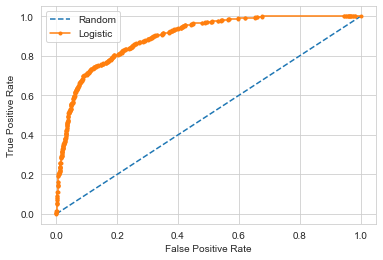

In [29]:
challenger_model(train_table,test_table,False,'Revenue')

In [16]:
cols_list = train_table.columns.tolist()
cols_list.remove('Revenue')

In [17]:
model_names = ['LGB', 'RF', 'GBM'] 
pima1_acc = []
pima1_f1 = []

lgb_clf = lgb.LGBMClassifier()
rf_clf = RandomForestClassifier()
gbm_clf = GradientBoostingClassifier()

clf_list = [lgb_clf,rf_clf,gbm_clf]
clf_dict = dict(zip(model_names,clf_list))

search_space = {"LGB":{'n_estimators':[15,20,25,100],
                        'feature_fraction': [0.5,0.7],
                        'bagging_fraction': [0.5,0.7],
                        'min_data_in_leaf': [5,10,15,20,100],
                        'max_depth': [3,5,7],
                         'min_split_gain': [0,2,5],
                         'num_leaves': [8,16,32,128]},
                    "RF": {'n_estimators': [25,100,300],
                        'criterion': ['gini', 'entropy'],
                        'bootstrap': [True, False]},
                    "GBM": {'n_estimators': [25,100,300],
                        'max_depth': [3,5,7],
                        'learning_rate': [0.01,0.05,0.2],
                        'loss': ['deviance', 'exponential']}}

def params_tuning(clf_dict,classifier_tag,search_space):
    '''
    input classifier_tag to tune, with targetted search space
    tags include RF, GBM, LGB
    '''
    #unpack search space, and classifier, according to tag
    grid_param = search_space[classifier_tag]
    classifier = clf_dict[classifier_tag]
    
    grid_search_obj = GridSearchCV(estimator=classifier, param_grid=grid_param, scoring='accuracy', cv=10,n_jobs=-1)

    grid_search_obj.fit(x_train2, y_train2)
    
    best_parameters = grid_search_obj.best_params_
    best_accuracy = grid_search_obj.best_score_
    
    print('Classifier: '+classifier_tag)
    print('best params found:',best_parameters)
    print('with training accuracy:',best_accuracy)
        
    #fit pima2
    y_pred2 = grid_search_obj.predict_proba(x_test2)[:,1]
    
    #pima2_f1_best = round(f1_score(y_test2, y_pred2, average='weighted')*100,2)
    #pima2_acc_best = round(accuracy_score(y_test2, y_pred2)*100,2)
    pima2_auc_best = round(roc_auc_score(y_test2, y_pred2)*100,2)
    
    #print('best accuracy (test set):', pima2_acc_best)
    #print('best f1_Score (test set):', pima2_f1_best)
    print('best auc_Score (test set):', pima2_auc_best)

    #print out confusion matrix on testing set
    #conf_matrix = confusion_matrix(y_test2, y_pred2)
    print('Confusion matrix on test set:')
    #print(conf_matrix)
    
    return grid_search_obj

In [25]:
x_train2,y_train2 = train_table[cols_list], train_table['Revenue']
x_test2,y_test2 = test_table[cols_list], test_table['Revenue']

In [ ]:
%%time
GBM_tuned_clf = params_tuning(clf_dict,'GBM',search_space)

In [26]:
%%time
RF_tuned_clf = params_tuning(clf_dict,'RF',search_space)

Classifier: RF
best params found: {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 300}
with training accuracy: 0.9064277802096626
best auc_Score (test set): 92.43
Confusion matrix on test set:
CPU times: user 5.07 s, sys: 394 ms, total: 5.46 s
Wall time: 2min 14s


In [109]:
%%time
LGB_tuned_clf = params_tuning(clf_dict,'LGB',search_space)

Classifier: LGB
best params found: {'bagging_fraction': 0.5, 'feature_fraction': 0.7, 'max_depth': 5, 'min_data_in_leaf': 100, 'min_split_gain': 0, 'n_estimators': 25, 'num_leaves': 16}
with training accuracy: 0.9091661169236588
best auc_Score (test set): 93.12
Confusion matrix on test set:
CPU times: user 2min 53s, sys: 14.1 s, total: 3min 7s
Wall time: 12min 47s


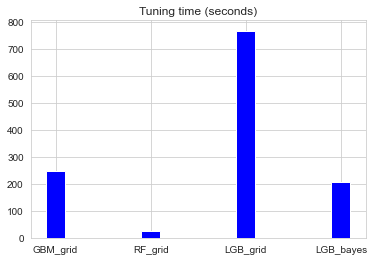

In [30]:
plt.title('Tuning time (seconds)')

plt.bar(['GBM_grid','RF_grid','LGB_grid','LGB_bayes'],height=[246,26,767,205],width=0.2,color='b')
plt.show()

## Now we use better model classifiers and do tuning

In [31]:
Train_cols = train_table.columns.tolist()
Train_cols.remove('Revenue')

train_features,train_target = train_table[Train_cols],train_table['Revenue']
test_features,test_target = test_table[Train_cols],test_table['Revenue']

In [32]:
%%time

data = lgb.Dataset(train_features.values,train_target.values)

def lgb_cv(n_estimators,feature_fraction,bagging_fraction,min_data_in_leaf,max_depth,min_split_gain,num_leaves,lambda_l1,lambda_l2,num_iterations=1000):
        params = {'objective':'binary','num_iterations': num_iterations, 'early_stopping_round':30, 'metric':'l1'}
        params['n_estimators'] = int(round(n_estimators))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params["min_data_in_leaf"] = int(round(min_data_in_leaf))
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain      
        params["num_leaves"] = int(round(num_leaves))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        
        cv_result = lgb.cv(params, data, nfold=5, seed=2, stratified=True, verbose_eval =50)
        return -(min(cv_result['l1-mean']))

lgb_bo = BayesianOptimization(
        lgb_cv,
        {'n_estimators': (10,100),
        'feature_fraction': (0.5, 1),
        'bagging_fraction': (0.5, 1),
        'min_data_in_leaf': (1,100),
        'max_depth': (3, 15),
         'min_split_gain': (0, 5),
         'num_leaves': (8, 128),
         'lambda_l1': (0, 100),
         'lambda_l2': (0, 100)},
        verbose=0)

lgb_bo.maximize(init_points=21,n_iter=90)
print (lgb_bo.max)

[50]	cv_agg's l1: 0.152812 + 0.00342354
[50]	cv_agg's l1: 0.164801 + 0.00268493
[50]	cv_agg's l1: 0.164721 + 0.0030388
[50]	cv_agg's l1: 0.15768 + 0.00289503
[50]	cv_agg's l1: 0.157963 + 0.00306187
[50]	cv_agg's l1: 0.154629 + 0.00326574
[50]	cv_agg's l1: 0.160525 + 0.00313586
[50]	cv_agg's l1: 0.17024 + 0.00288979
[50]	cv_agg's l1: 0.165379 + 0.00305417
[50]	cv_agg's l1: 0.162988 + 0.00320241
[50]	cv_agg's l1: 0.169804 + 0.00257945
[50]	cv_agg's l1: 0.146878 + 0.00349949
[50]	cv_agg's l1: 0.146418 + 0.00347764
[50]	cv_agg's l1: 0.138542 + 0.00334849
[50]	cv_agg's l1: 0.16848 + 0.00271483
[50]	cv_agg's l1: 0.144022 + 0.00331526
[50]	cv_agg's l1: 0.149774 + 0.00338158
[50]	cv_agg's l1: 0.15103 + 0.00287383
[50]	cv_agg's l1: 0.142133 + 0.00345737
[50]	cv_agg's l1: 0.136651 + 0.00335913
[50]	cv_agg's l1: 0.143682 + 0.0034468
[50]	cv_agg's l1: 0.160053 + 0.00321125
[50]	cv_agg's l1: 0.140547 + 0.00308546
[50]	cv_agg's l1: 0.152244 + 0.00319801
[50]	cv_agg's l1: 0.14036 + 0.0033142
[50]	cv_

In [33]:
train_features = train_features.reset_index().drop(columns='index')
train_target = train_target.reset_index()['Revenue']

In [34]:
best_params = lgb_bo.max['params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_data_in_leaf'] = int(best_params['min_data_in_leaf'])
best_params['n_estimators'] = int(best_params['n_estimators'])

optimized = lgb.LGBMClassifier(**best_params)

In [35]:
optimized.fit(train_features,train_target)
predictors=list(train_features)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.927


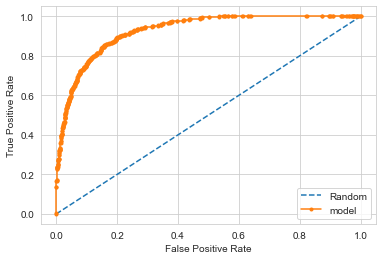

In [36]:
plot_auc(train_table,test_table,'Revenue',optimized)

In [37]:
cols_f = train_features.columns.tolist()
importance = list(optimized.feature_importances_)

res = []
for i,v in enumerate(importance):
    col = cols_f[i]
    res.append([col,v])
    
importance_sorted = sorted(res, key=lambda x: x[1])
cols = [a[0] for a in importance_sorted]
vals = [a[1] for a in importance_sorted]

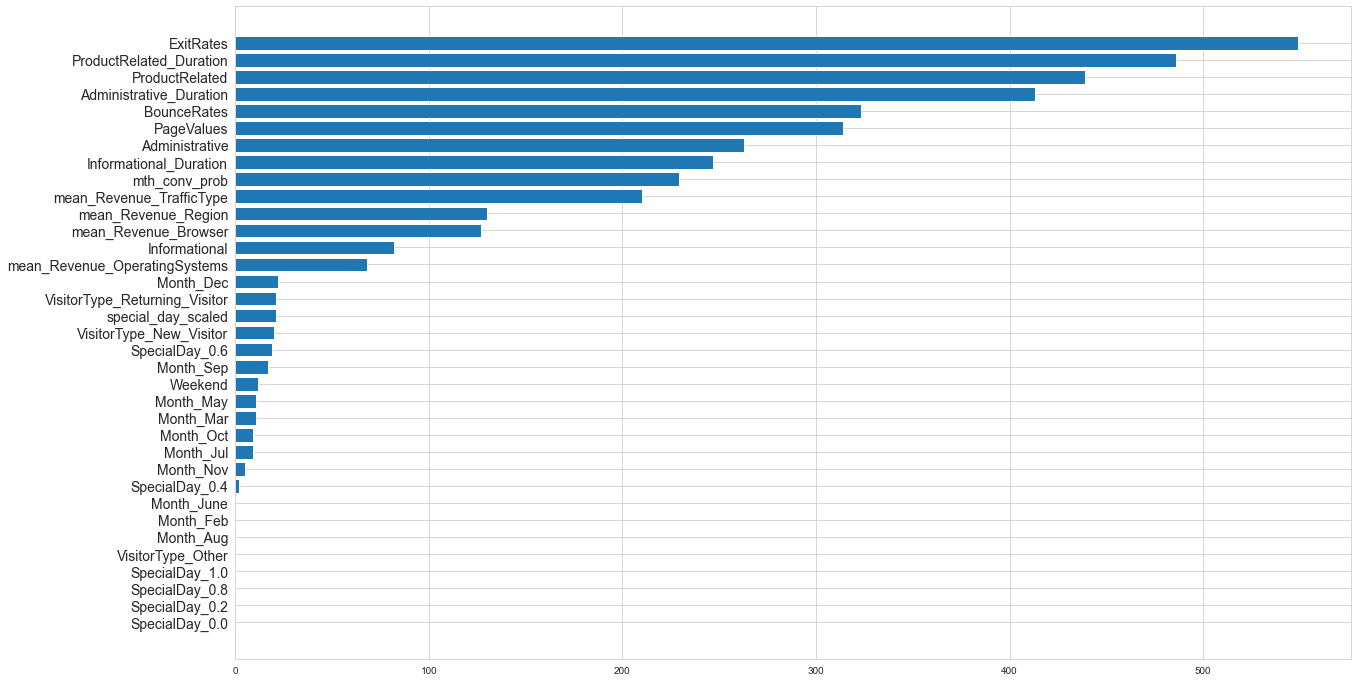

In [38]:
plt.figure(figsize = (20,12))
plt.barh(cols, vals)
plt.yticks(cols, fontsize=14)
plt.show()

## Now we use neural network

In [39]:
def load_data():

    train = pd.read_csv('train.csv')
    train.drop(train.columns[0], inplace = True, axis = 1)
    test = pd.read_csv('test.csv')
    test.drop(test.columns[0], inplace = True, axis = 1)
    
    y_train = train['Revenue']
    y_test = test['Revenue']
    X_train = train.iloc[:,:-1]
    X_test = test.iloc[:,:-1]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data()

In [40]:
## onehot encoding + standardization
def preprocess(train_data, test_data, cate_columns, num_columns):
    
    scaler1 = StandardScaler()
    scaler2 = OneHotEncoder(drop='first')
    train_data_num = train_data[num_columns]
    test_data_num = test_data[num_columns]
    train_data_cate = []
    test_data_cate = []
    
    ## Standard Scaler transformation
    for col in num_columns:
        scaler1.fit(train_data[col].values.reshape(-1,1))
        train_data_num[col] = scaler1.transform(train_data[col].values.reshape(-1,1))
        test_data_num[col] = scaler1.transform(test_data[col].values.reshape(-1,1))
        
    ## One-hot encoding
    for col in cate_columns:
        scaler2.fit(train_data[col].values.reshape(-1,1))
        train_data_cate.append(scaler2.transform(train_data[col].values.reshape(-1,1)).toarray())
        test_data_cate.append(scaler2.transform(test_data[col].values.reshape(-1,1)).toarray())
        
    train_data_cate = np.concatenate(train_data_cate, axis = 1)
    test_data_cate = np.concatenate(test_data_cate, axis = 1)
    
    train_data_final = np.concatenate([train_data_num,train_data_cate], axis = 1)
    test_data_final = np.concatenate([test_data_num,test_data_cate], axis = 1)
    
    return train_data_final, test_data_final

cate_columns = ['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']
num_columns = [x for x in X_train.columns if x not in cate_columns]

X_train, X_test = preprocess(X_train, X_test, cate_columns, num_columns)

In [42]:
## model architect
model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dropout(rate = 0.75))
model.add(Dense(5, activation='relu'))
#model.add(Dropout(rate = 0.75))
model.add(Dense(1, activation='sigmoid'))
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights=True)
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer=Nadam(lr=1e-4, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])
# fit the keras model on the dataset
history = model.fit(X_train, y_train, epochs=300, validation_split=0.2 ,batch_size=10,callbacks = [es], shuffle = True, verbose = 20)


Train on 7891 samples, validate on 1973 samples
Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300

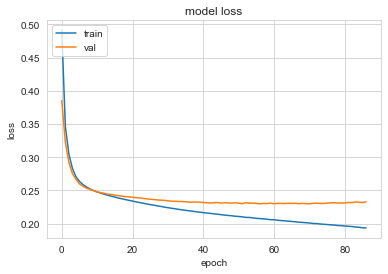

In [43]:
## plot training and test loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [44]:
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

train_auc = roc_auc_score(y_train, predicted_train)
test_auc = roc_auc_score(y_test, predicted_test)
# summarize scores
print('Train: ROC AUC=%.3f' % (train_auc))
print('Test: ROC AUC=%.3f' % (test_auc))

Train: ROC AUC=0.941
Test: ROC AUC=0.916


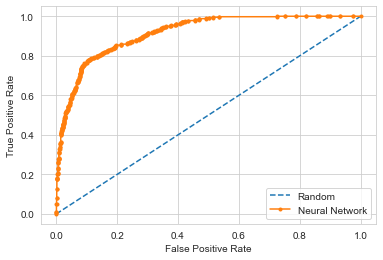

In [45]:
predicted_ns = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, predicted_ns)
lr_fpr, lr_tpr, _ = roc_curve(y_test, predicted_test)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

## Ensemble Methods - stacking neural network and GBDT

In [46]:
## predicted value of LGB and NN
predicted_train_lgb = optimized.predict_proba(train_features)[:,1].reshape(-1,1)
predicted_test_lgb = optimized.predict_proba(test_features)[:,1].reshape(-1,1)
predicted_train_nn = predicted_train
predicted_test_nn = predicted_test

stack_train = np.concatenate([predicted_train_lgb, predicted_train_nn], axis = 1)
stack_test = np.concatenate([predicted_test_lgb, predicted_test_nn], axis = 1)

In [47]:
## Use LightGBM as the meta-learner for stacking
lgb_stack = lgb.LGBMClassifier(max_depth=5, learning_rate=0.01, subsample=0.9)
lgb_stack.fit(X = stack_train, y = train_target)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

In [48]:
predicted_train_ensemble = lgb_stack.predict_proba(stack_train)[:,1]
predicted_test_ensemble = lgb_stack.predict_proba(stack_test)[:,1]

train_auc_ensemble = roc_auc_score(train_target, predicted_train_ensemble)
test_auc_ensemble = roc_auc_score(test_target, predicted_test_ensemble)
# summarize scores
print('Train: ROC AUC=%.3f' % (train_auc))
print('Test: ROC AUC=%.3f' % (test_auc))

Train: ROC AUC=0.941
Test: ROC AUC=0.916


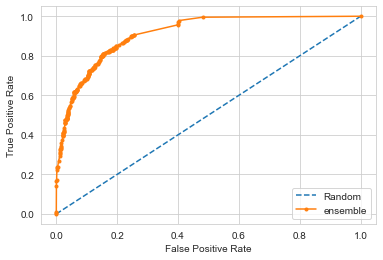

In [49]:
predicted_ns = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, predicted_ns)
lr_fpr, lr_tpr, _ = roc_curve(y_test, predicted_test_ensemble)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
plt.plot(lr_fpr, lr_tpr, marker='.', label='ensemble')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()